### Import Required Libraries

We import the core Python libraries required for data manipulation, path handling, and exploratory analysis.

In [1]:
import pandas as pd
from pathlib import Path


### Loading the Training and Test Datasets

The training and test datasets are loaded from the `data/` directory. Paths are resolved explicitly to avoid issues with relative locations.
These datasets will be used for exploratory data analysis and feature engineering.

In [2]:

train_path = Path("../data/train.csv").resolve()

out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

train_out_path = out_dir / "train_cleaned.csv"



In [3]:
train_data = pd.read_csv(train_path)


### Previewing the Training Data

A quick preview helps verify that the data has loaded correctly and provides an initial sense of feature types and values.


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [15]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Inspecting Dataset Structure and Data Types

The info() method provides a concise summary of the dataset, including:

1. Number of entries

2. Column names

3. Data types

4. Count of non-null values

This is especially useful for identifying missing values.

In [ ]:
train_data.info()

### Statistical Summary of Numerical Features

The describe() method generates descriptive statistics for numerical columns, such as:

1. Mean

2. Standard deviation

3. Minimum and maximum values

4. Quartiles

This gives an overview of data distribution and potential anomalies.

In [ ]:
train_data.describe()

### Identifying Missing Age Values

Here we filter the dataset to show only rows where the Age column has missing values (NaN).
This helps us understand how many records are affected and plan an imputation strategy.

In [ ]:
train_data[train_data['Age'].isna()]

### Extract Passenger Titles from Names

Passenger titles (e.g., Mr, Mrs, Miss) are extracted from the Name column using a regular expression.
Titles often capture social status and correlate strongly with age and survival.

In [4]:
train_data['Title'] = train_data['Name'].str.extract(r',\s*([^\.]+)\.')


### Grouping Rare Titles

Many titles appear very infrequently.
To reduce noise and dimensionality, we group uncommon titles into a single category called "Rare".

In [5]:
train_data['Title'] = train_data['Title'].where(
train_data['Title'].isin(['Mr', 'Mrs', 'Master', 'Miss']),
'Rare'
)


### Encoding Titles as Numerical Values

Machine learning models require numerical inputs.
Here we map each title category to an integer value for model compatibility.

### Impute Missing Age Values Using Training Data Only

Missing values in the Age column are filled using the average age per title, calculated only from the training data.
This avoids data leakage while producing more realistic age estimates.

In [9]:
title_age_means = (
    train_data
    .groupby('Title')['Age']
    .mean()
)

for title, avg_age in title_age_means.items():
    train_data.loc[
        (train_data['Title'] == title) & (train_data['Age'].isna()),
        'Age'
    ] = round(avg_age, 2)



### Validating the Sex Column

We check whether the Sex column contains only the expected values (male, female).
This ensures data consistency before encoding.

In [10]:
train_data[~train_data['Sex'].isin(['male', 'female'])]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


### Encoding Sex as Numerical Values

We convert the categorical Sex column into numeric form:

male → 0

female → 1

This is required for machine learning algorithms.

In [11]:
train_data['Sex'] = train_data['Sex'].map({
    'male': 0,
    'female': 1
})


### Exploring the Embarked Feature

We inspect the Embarked column, which represents the port where passengers boarded the ship.

In [12]:
train_data['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: str

### Validating Embarked Values

This step checks for unexpected or invalid embarkation values outside the known categories:

S (Southampton)

C (Cherbourg)

Q (Queenstown)

In [13]:
train_data[~train_data['Embarked'].isin(['S','C','Q'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,Mrs


### Handling Missing Embarked Values

Missing values in Embarked are filled with 'C', which is the most frequent embarkation port in this dataset.
This ensures no missing values remain in this feature.

In [14]:
train_data['Embarked'] = train_data['Embarked'].fillna('C')


### Detection of outliers
Using IQR method for fare

In [ ]:
Q1 = train_data["Fare"].quantile(0.25)
Q3 = train_data["Fare"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = train_data[(train_data["Fare"] < lower) | 
                      (train_data["Fare"] > upper)]

print(len(outliers))

# Fare data is highly skewed. We keep the fare data as is, since probably most people pay the very low fare , few people pay really
# high fare price, and all 3 person who payed the highest fare (512.3292) survived, 


116


In [ ]:
train_data[train_data["Fare"]>300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


### Outlier Analyze for Age
Use Z score and histgram(distribution)
Age is approximately normally distributed and bounded within realistic human limits. we keep it as is.

In [20]:
from scipy.stats import zscore
import numpy as np

z_scores = zscore(train_data["Age"])

outliers = train_data[np.abs(z_scores) > 3]

print("Number of Age outliers:", len(outliers))

Number of Age outliers: 0


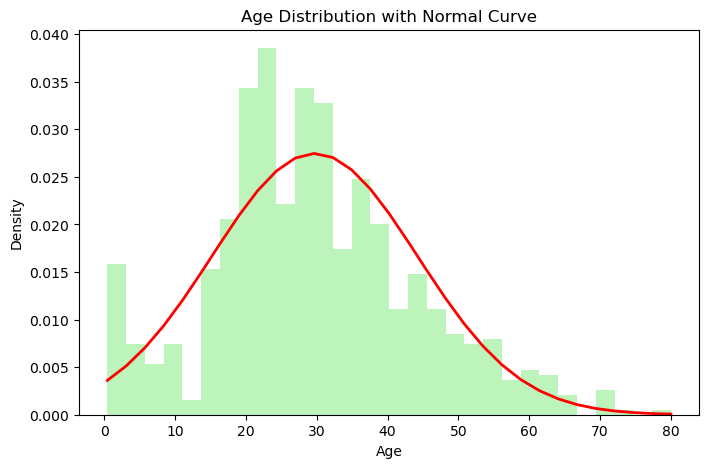

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt
ages = train_data["Age"]
mu = ages.mean()
sigma = ages.std()

# Plot histogram
plt.figure(figsize=(8,5))
count, bins, ignored = plt.hist(ages, bins=30, density=True, color='lightgreen', alpha=0.6)

# Overlay normal distribution curve
plt.plot(bins, norm.pdf(bins, mu, sigma), color='red', linewidth=2)
plt.title("Age Distribution with Normal Curve")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()



### Final Data Validation

As a final check, we confirm that there are no unexpected missing values remaining in either dataset.

In [ ]:
print("Train missing values:")
print(train_data.isna().sum())


### Export Cleaned Datasets to CSV Files

The cleaned datasets are saved as CSV files for use in modeling and experimentation.

In [15]:
train_data.to_csv(train_out_path, index=False)

